In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.decomposition import PCA

import torch.optim as optim
from torchvision.utils import save_image

/home/amir/miniconda3/envs/qml_torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/amir/miniconda3/envs/qml_torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### parameters

In [3]:
size_dataset = 1000
data_dimensions = 4

### Dataset preprocessing

In [4]:
import torch
import torchvision
from torchvision import datasets, transforms

In [5]:
transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset = datasets.MNIST(root="~/.mnist", train=True, download=True,
                       transform=transform)

In [6]:
train_images = torch.stack([image.flatten() for image, label in dataset])
train_labels = torch.tensor([label for image, label in dataset])

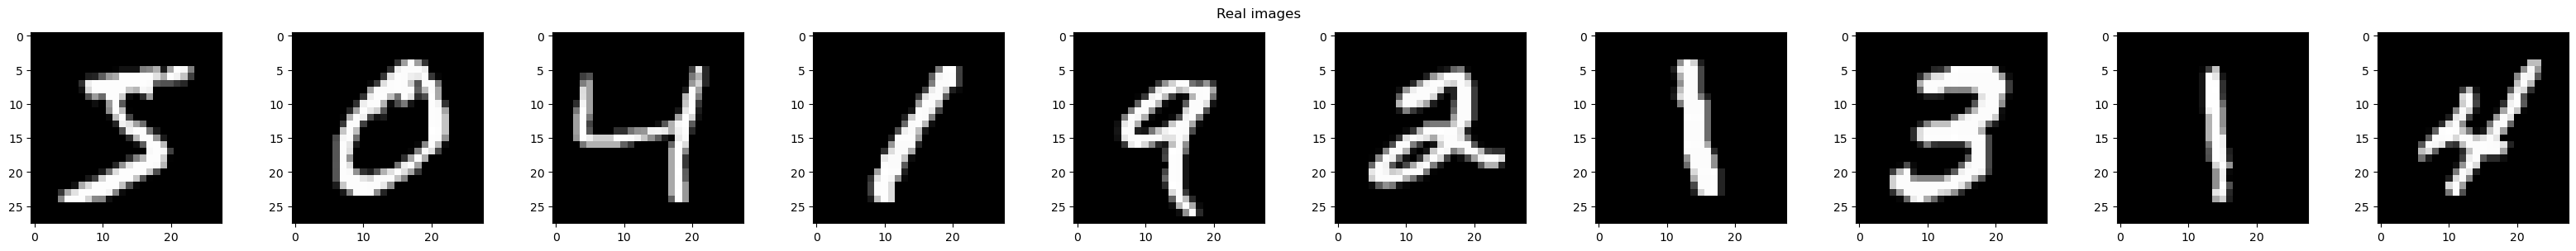

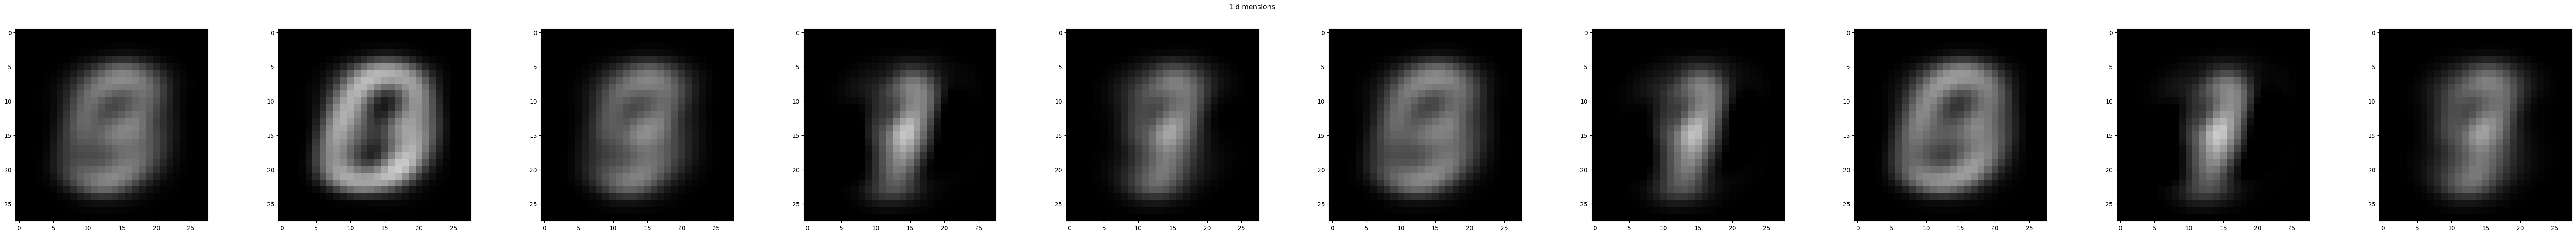

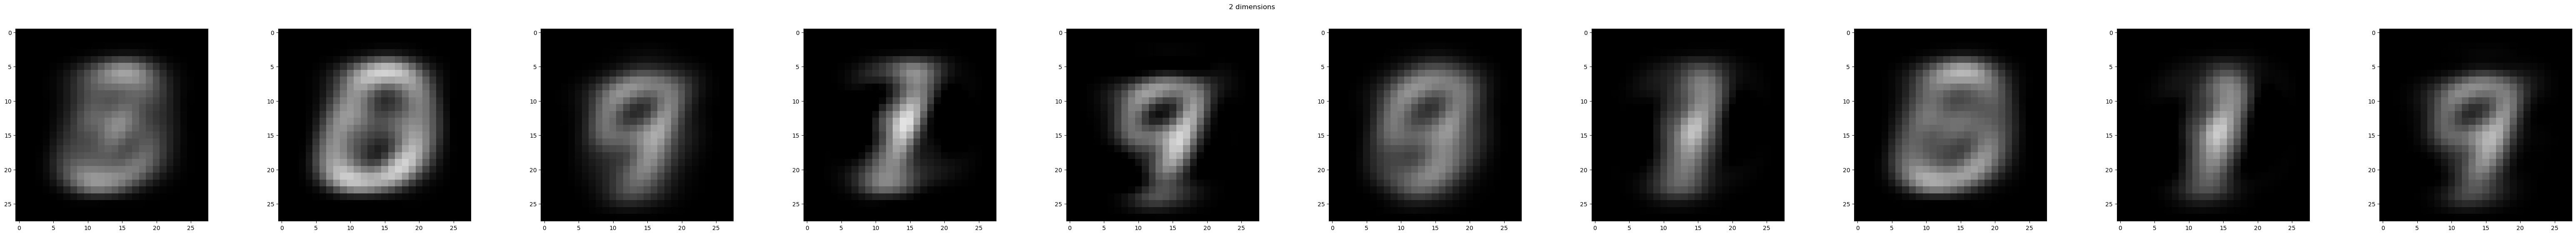

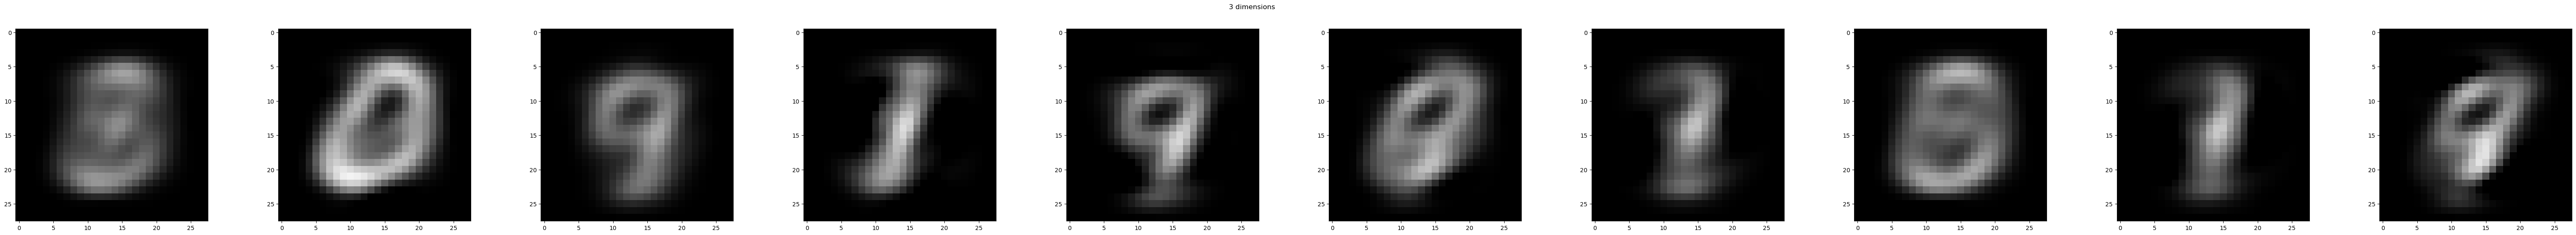

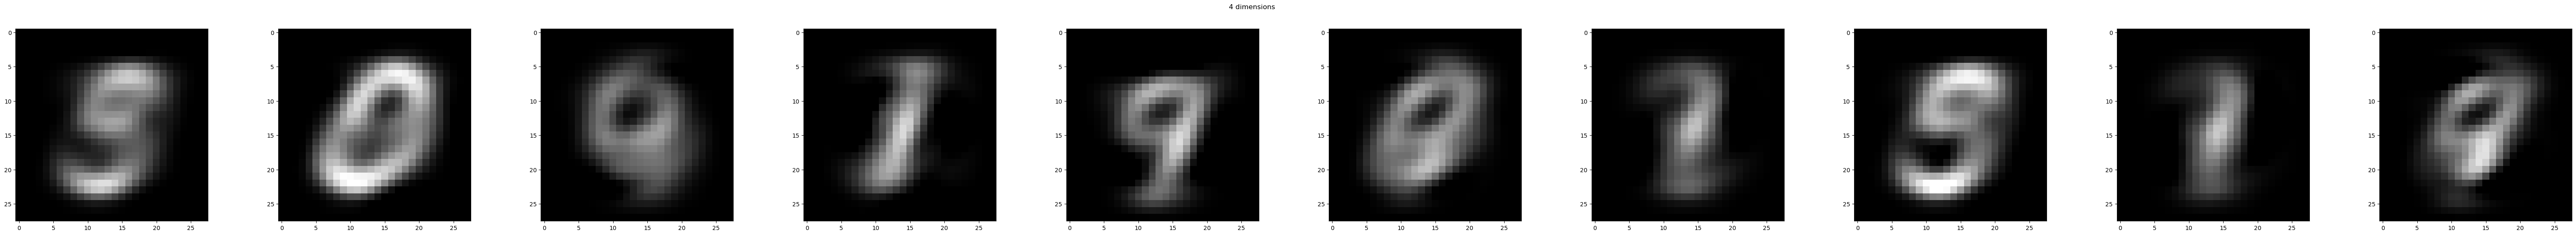

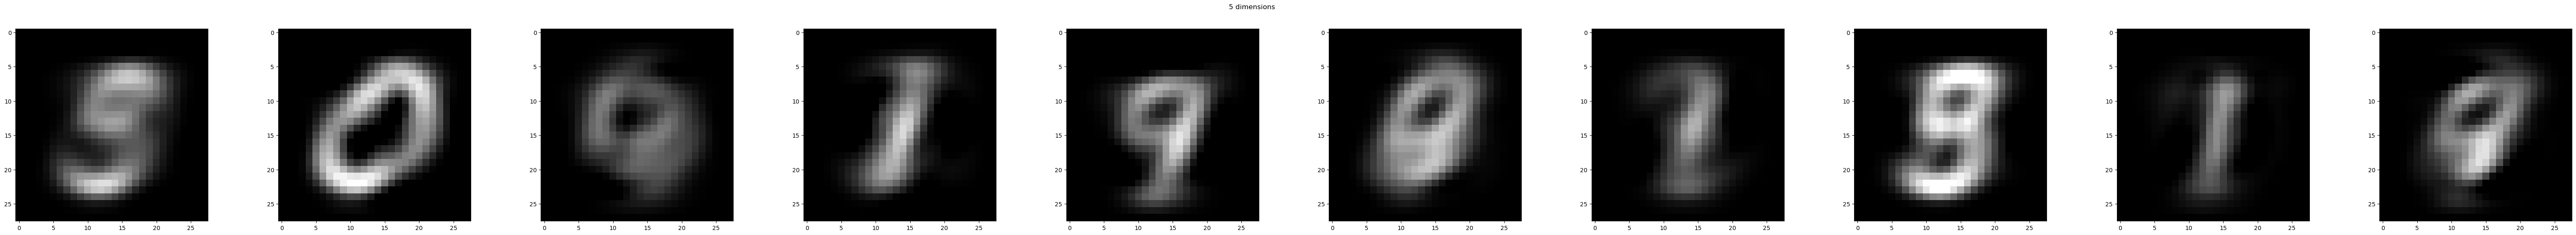

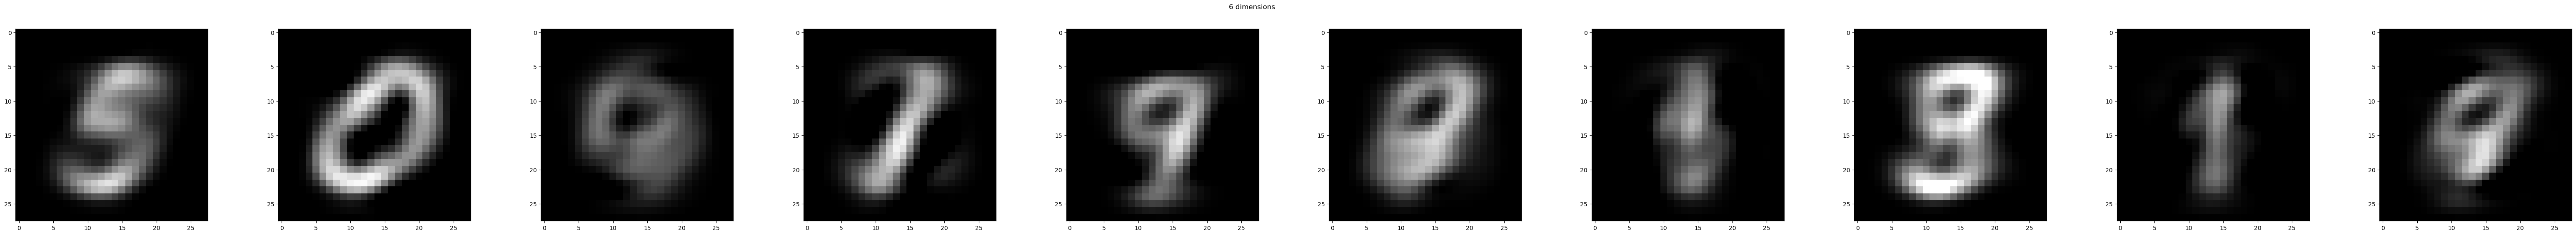

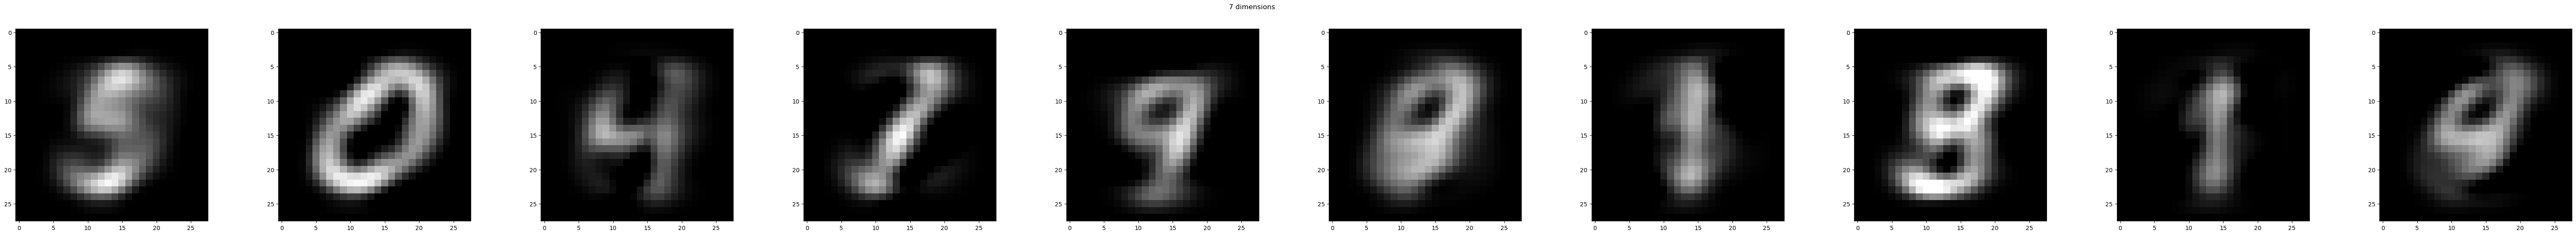

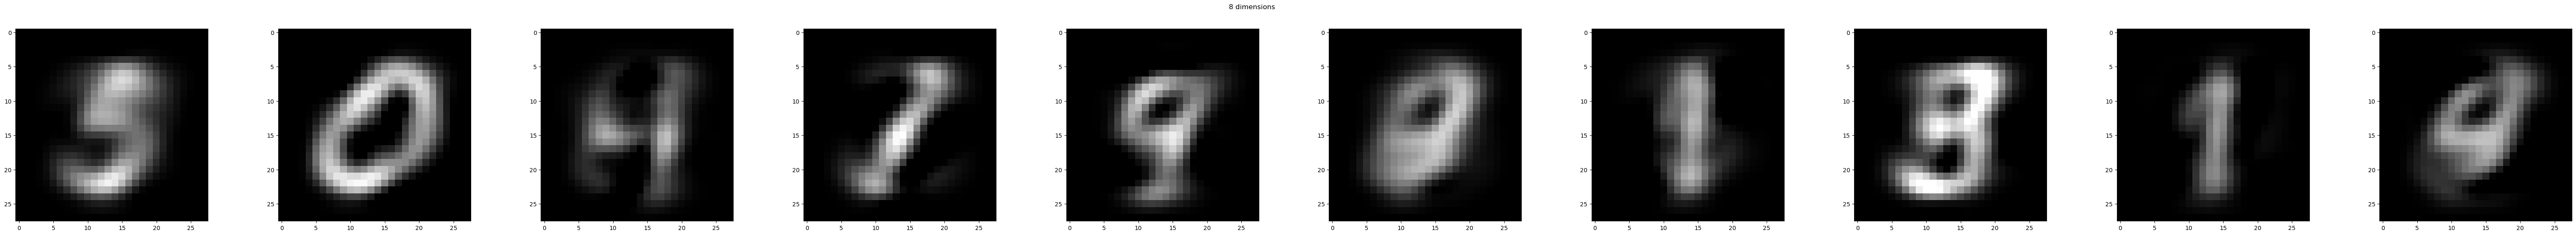

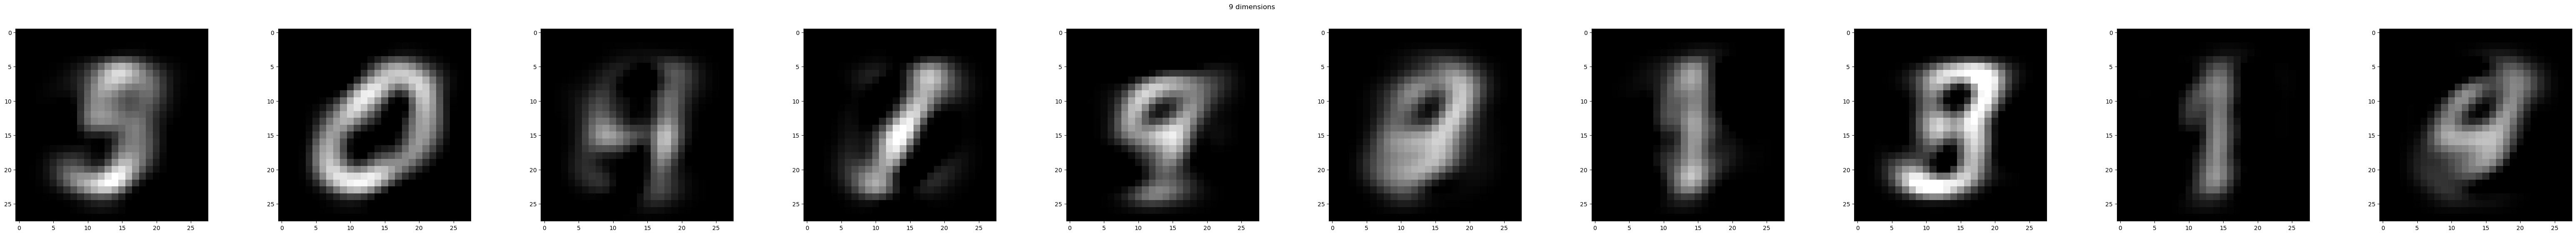

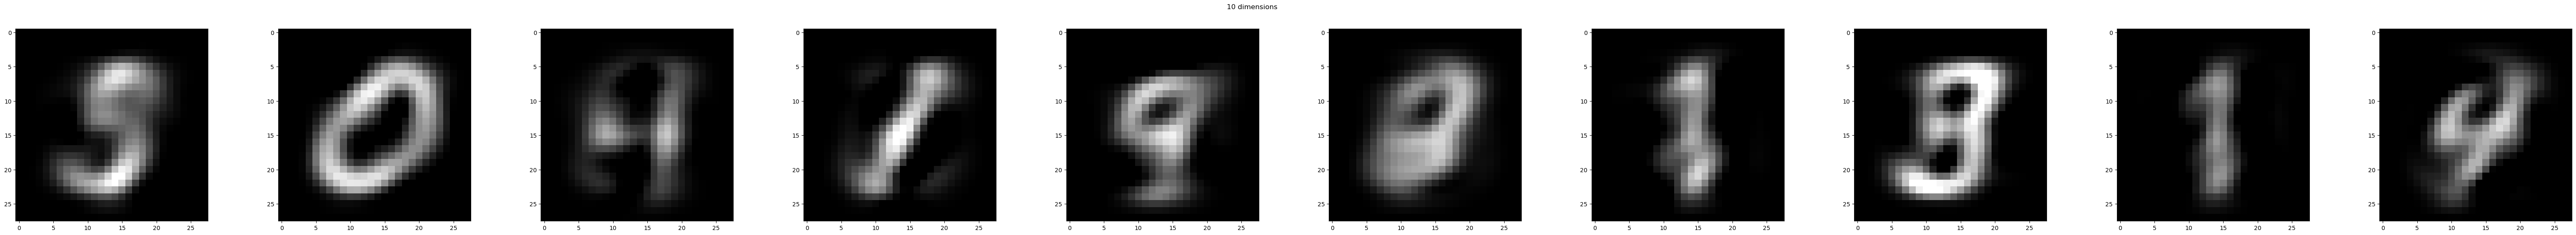

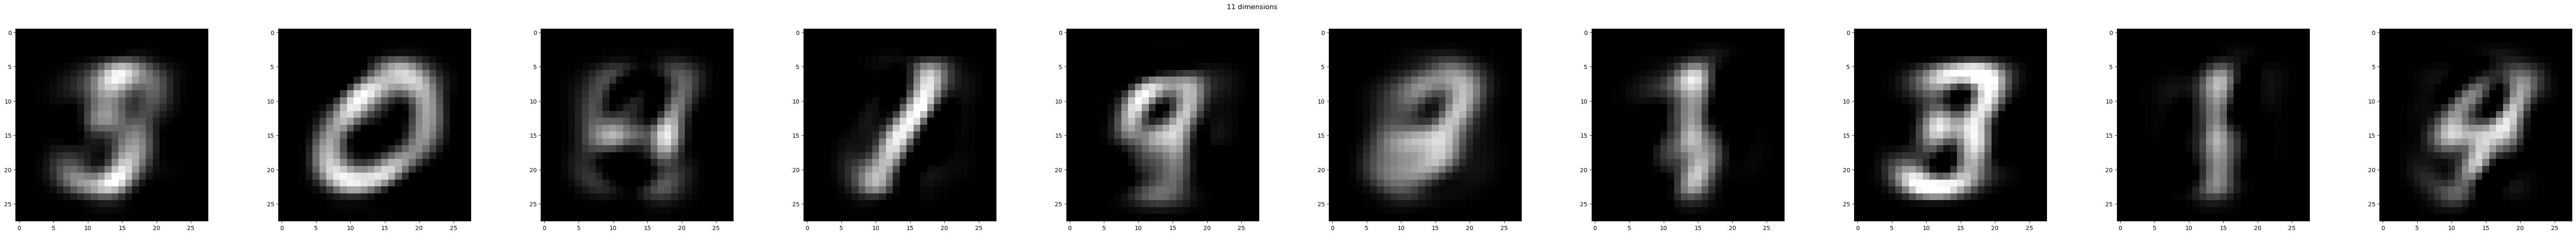

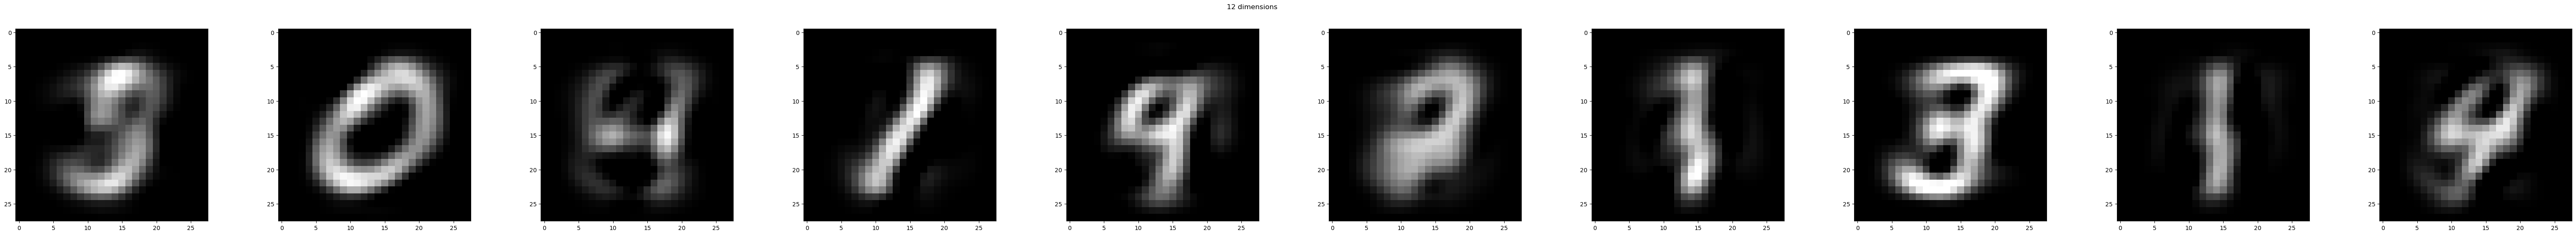

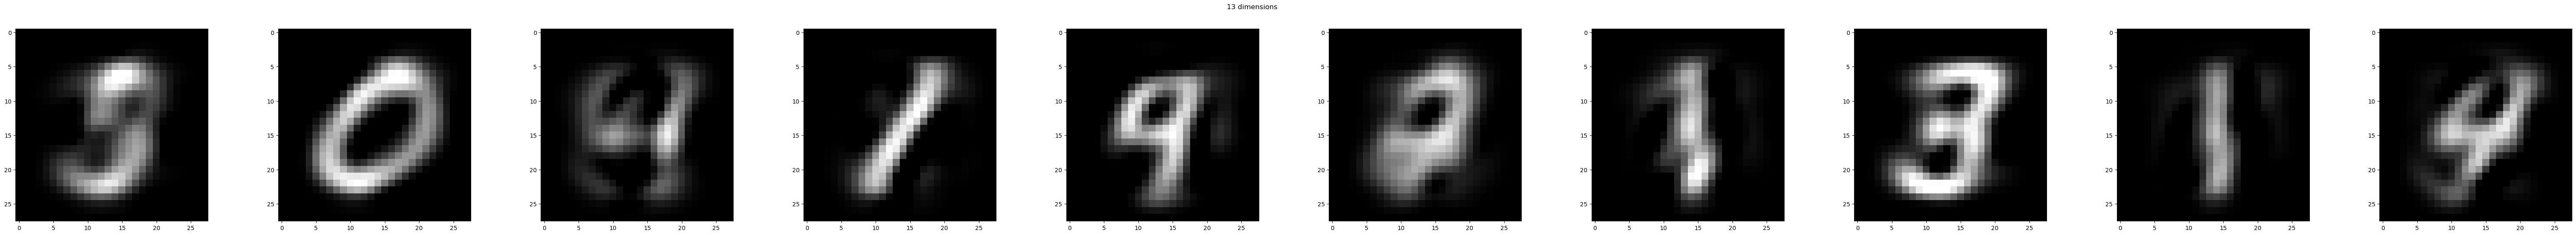

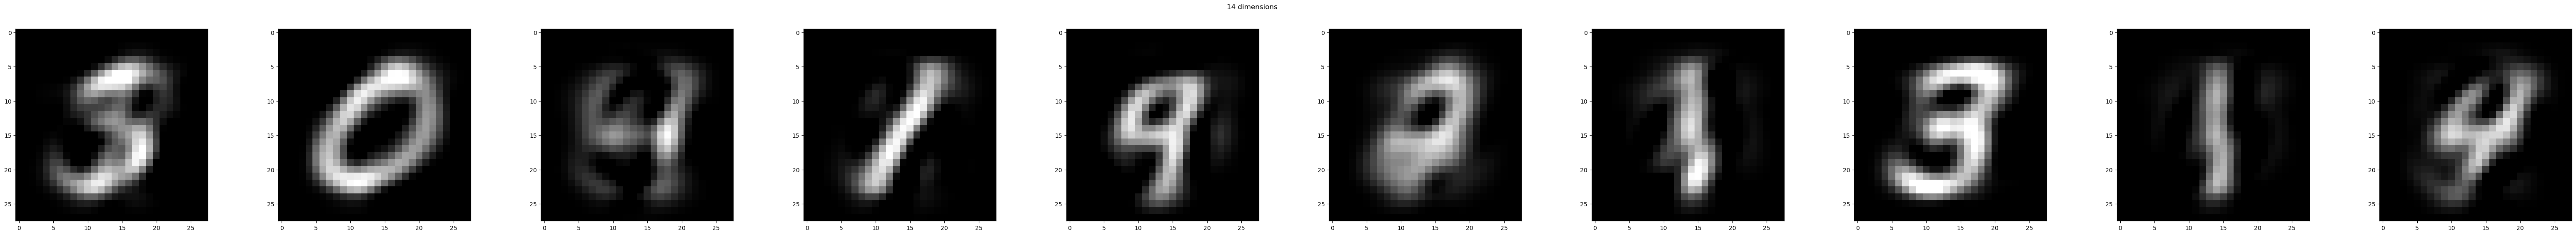

In [68]:
# temp testing cell
# visualizing different dimensions reconstruction images
n_images = 10
    
plt.figure(figsize=(4*n_images, 3))
mixed_images = (train_images[:n_images])

plt.suptitle(f"Real images")
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.imshow(mixed_images[i].reshape(28, 28), cmap="gray", vmin=0, vmax=1)
plt.show()

for dimension in range(1, 15):
    plt.figure(figsize=(8*n_images, 6))
     
    pca = PCA(n_components=dimension)
    pca.fit(train_images)
    mixed_images = pca.inverse_transform(pca.transform(train_images[:n_images]))
    
    plt.suptitle(f"{dimension} dimensions")
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(mixed_images[i].reshape(28, 28), cmap="gray", vmin=0, vmax=1)
    plt.show()

In [7]:
# --------------------------------------------------
# ---------------- PCA Section ---------------------
# --------------------------------------------------
k=data_dimensions
pca = PCA(n_components=k)
pca.fit(train_images)
pca_data = pca.transform(train_images).astype(np.float32)

valid_labels = (train_labels == 3) | (train_labels == 6) | (train_labels == 9)

pca_data = pca_data[valid_labels][:size_dataset]
data_labels = train_labels[valid_labels][:size_dataset]

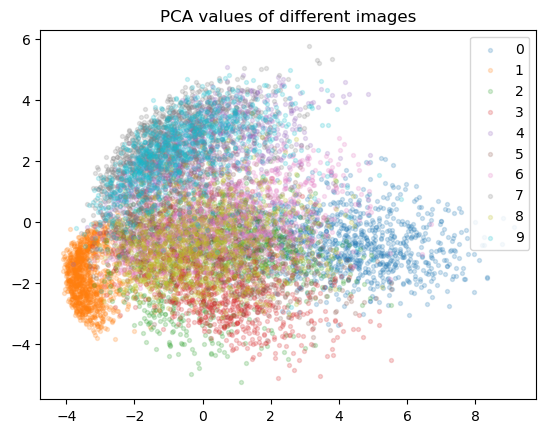

In [51]:
# temp testing cell
# visualizing pca mnist
labels = train_labels.unique()
for l in labels:
    index = train_labels == l
    plt.scatter(pca_data[index, 0], pca_data[index, 1], label=l.item(), alpha=0.2, s=8)
plt.legend()
plt.title("PCA values of different images")
None

In [9]:
# --------------------------------------------------
# --------  Normalize vector components ------------
# --------------------------------------------------
pca_descaler = [[] for _ in range(k)]
for i in range(k):
    if pca_data[:,i].min() < 0:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] += np.abs(pca_data[:,i].min())
    else:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] -= pca_data[:,i].min()
    pca_descaler[i].append(pca_data[:,i].max())
    pca_data[:,i] /= pca_data[:,i].max()


train_dataset = pca_data

print(f"The Total Explained Variance of {k} Dimensions is {sum(pca.explained_variance_ratio_).round(3)}")

# --------------------------------------------------
# Define a function that can take in PCA'ed data and return an image
# --------------------------------------------------
def descale_points(d_point,scales=pca_descaler,tfrm=pca):
    for col in range(d_point.shape[1]):
        d_point[:,col] *= scales[col][1]
        d_point[:,col] += scales[col][0]
    reconstruction = tfrm.inverse_transform(d_point)
    return reconstruction

The Total Explained Variance of 4 Dimensions is 0.284


In [10]:
# Hyperparameters
batch_size = 10
num_epochs = 1
g_lr = 1e-1
d_lr = 1e-2

quantum = True

### Pennylane quantum model

In [11]:
n_qubits = data_dimensions
use_noise = True

In [12]:
dev = qml.device("default.qubit", wires=n_qubits)
diff_method = "adjoint"

In [13]:
d_params = torch.from_numpy(np.random.uniform(0, 2*np.pi, size=(3, n_qubits))).requires_grad_(True)  # todo add multiple layers support
g_params = torch.from_numpy(np.random.uniform(0, 2*np.pi, size=(3, n_qubits))).requires_grad_(True)

In [14]:
def generator_circ(noise, params):
    if use_noise:
        for i in range(n_qubits):
            qml.RX(noise[i], wires=i)
    
    params = params.reshape(-1, n_qubits)
    for i in range(n_qubits):
        qml.RY(params[0, i], wires=i)
    for i in range(n_qubits):
        qml.IsingYY(params[1, i], wires=[i, (i+1)%n_qubits])
    for i in range(n_qubits):
        qml.CRY(params[1, i], wires=[i, (i+1)%n_qubits])
    # todo try with different axes rotations
    
def data_loading_circ(values):
    assert len(values) == n_qubits
    assert min(values) >= -1, max(values) <= 1
    for i in range(n_qubits):
        qml.RY(np.arccos(values[i]), wires=i)

# todo check whether adjoining this circuit slows down learning.
def discriminator(params):
    for i in range(n_qubits):
        qml.RY(params[0, i], wires=i)
    for i in range(n_qubits):
        qml.IsingYY(params[1, i], wires=[i, (i+1)%n_qubits])
    for i in range(n_qubits):
        qml.CRY(params[1, i], wires=[i, (i+1)%n_qubits])
    
    
@qml.qnode(dev, diff_method="adjoint")
def sample(noise, params):
    generator_circ(noise, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, diff_method=diff_method)
def discriminate_generated_circ(input, real=True):
    if real:
        data_loading_circ(input)
    else:
        generator_circ(input, g_params)
    qml.adjoint(discriminator)(d_params)
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

# todo compare speed of this with: 
    # return qml.probs(wires=range(n_qubits))
    # + take [0] element when using (but doesn't support adjoint diff)
    
projector = torch.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1


In [57]:
# temp testing cell
# check data loading circuit
@qml.qnode(dev)
def data_loading_circ_qnode(x):
    data_loading_circ(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
x = torch.tensor(np.linspace(-1, 1, n_qubits))
outputs = torch.stack(data_loading_circ_qnode(x))       # to convert into probs:  /(-2)+0.5
print(x)
print(outputs)
print("mean diff is", torch.mean(torch.abs(x-outputs)))
assert torch.mean(torch.abs(x-outputs)) < 0.01

tensor([-1.0000, -0.3333,  0.3333,  1.0000], dtype=torch.float64)
tensor([-1.0000, -0.3333,  0.3333,  1.0000], dtype=torch.float64)
mean diff is tensor(0., dtype=torch.float64)


In [15]:
def discim_real(data):
    return torch.stack([discriminate_generated_circ(x, real=True)[None] for x in data]).type(data.dtype)

def discrim_fake(z):
    '''
    generates probabilities for discriminator learning
    '''
    return torch.stack([discriminate_generated_circ(noise, real=False)[None] for noise in z]).type(z.dtype)

def gen_data(noise):
    return [sample(x, g_params) for x in noise]



In [16]:
d_optimizer = optim.Adam([d_params], lr=d_lr)
g_optimizer = optim.Adam([g_params], lr=g_lr)

In [17]:
latent_size=n_qubits
device = torch.device('cpu')

### classical model

In [ ]:
import torch.nn as nn

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
image_size = data_dimensions
latent_size = 10
hidden_size = 10

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, image_size),
            nn.Sigmoid()  # To ensure pixel values are in the range [0, 1]
        )

    def forward(self, x):
        return self.model(x)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    def predict_real(self, data):
        return self.model(data)
    def predict_fake(self, noise):
        return self.model(self.gen(noise).detach())
    

# Initialize models and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr)
g_optimizer = optim.Adam(generator.parameters(), lr=g_lr)

def discim_real(data):
    return discriminator(data)
def discrim_fake(noise):
    return discriminator(generator(noise))
def gen_data(noise):
    return generator(noise)


## Learning

Epoch [1/1], Step [1/100], Discriminator Loss: 1.4822, Generator Loss: 3.4134
Epoch [1/1], Step [2/100], Discriminator Loss: 1.3401, Generator Loss: 3.0318
Epoch [1/1], Step [3/100], Discriminator Loss: 1.3704, Generator Loss: 3.9252
Epoch [1/1], Step [4/100], Discriminator Loss: 1.4088, Generator Loss: 2.5190
Epoch [1/1], Step [5/100], Discriminator Loss: 1.3798, Generator Loss: 2.9214
Epoch [1/1], Step [6/100], Discriminator Loss: 1.4132, Generator Loss: 3.0857
Epoch [1/1], Step [7/100], Discriminator Loss: 1.4330, Generator Loss: 2.5541
Epoch [1/1], Step [8/100], Discriminator Loss: 1.4330, Generator Loss: 2.2579
Epoch [1/1], Step [9/100], Discriminator Loss: 1.3049, Generator Loss: 3.0510
Epoch [1/1], Step [10/100], Discriminator Loss: 1.4639, Generator Loss: 2.2926
Epoch [1/1], Step [11/100], Discriminator Loss: 1.4403, Generator Loss: 2.4479
Epoch [1/1], Step [12/100], Discriminator Loss: 1.4551, Generator Loss: 2.0761
Epoch [1/1], Step [13/100], Discriminator Loss: 1.3006, Gener

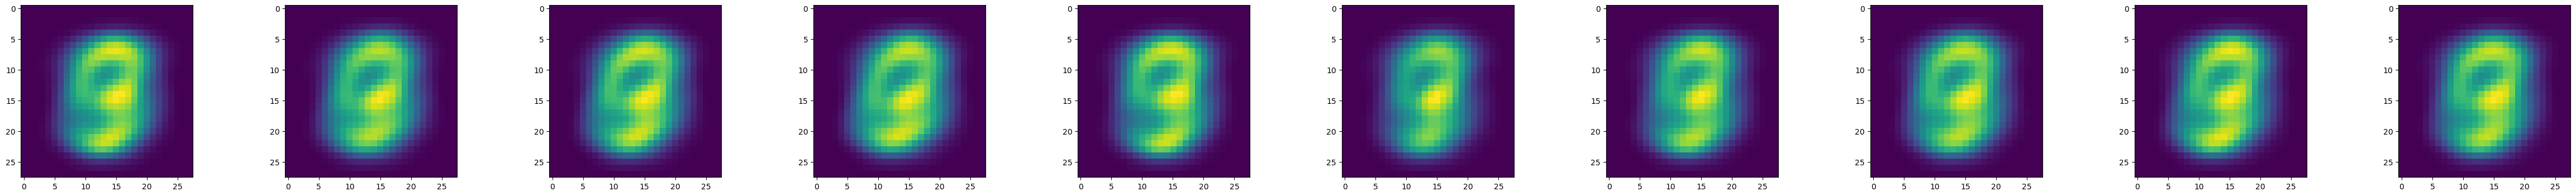

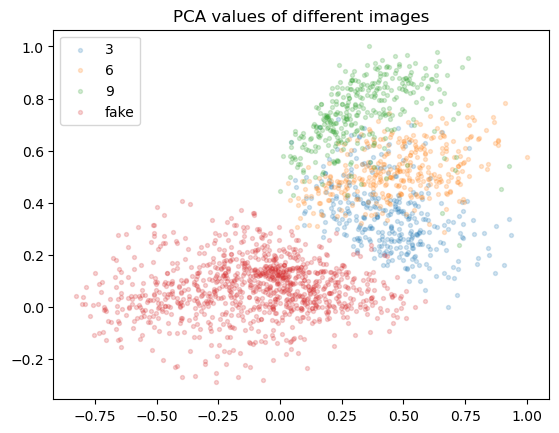

Time for inference is 25.015411376953125 sec


In [18]:
# ----- Learning -------
criterion = torch.nn.BCELoss()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def get_latent(size):
    return torch.randn(size, latent_size).to(device)

def fit_epoch():
    for i, images in enumerate(train_loader):
        batch_size = images.size(0)
        images = images.view(batch_size, -1).to(device)

        # Create real and fake labels for the loss functions
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the discriminator
        # Real images
        outputs = discim_real(images)
        d_loss_real = criterion(outputs, real_labels)
        

        # Fake images
        z = get_latent(batch_size)
        outputs = discrim_fake(z)
        d_loss_fake = criterion(outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        # Backprop and optimize discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        z = get_latent(batch_size)
        outputs = discrim_fake(z)   # todo check whether it is possible to reuse previous computation ouf this outputs
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print progress
        if (i + 1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}')
        
def inference():
    # generate images
    with torch.no_grad():
        fake_data = gen_data(get_latent(64))
        fake_images = torch.tensor(pca.inverse_transform(fake_data), dtype=torch.float32)
        save_image(fake_images.view(fake_images.size(0), 1, 28, 28),
                f'generated_images_epoch_{epoch + 1}.png')
        plt.figure(figsize=(6*10, 4))
        for i in range(10):
            plt.subplot(1, 10, i+1)
            plt.imshow(fake_images[i].view(28, 28))
        plt.show()
        
    # compare distributions
    
    vis_dims = [0, 1]
    n_samples = 1000
    with torch.no_grad():
        fake_data = np.array(gen_data(get_latent(n_samples)))
    

    labels = data_labels.unique()
    for l in labels:
        index = data_labels == l
        plt.scatter(pca_data[index, vis_dims[0]], 
                    pca_data[index, vis_dims[1]], label=l.item(), alpha=0.2, s=8)
    plt.title("PCA values of different images")
    plt.scatter(fake_data[:, vis_dims[0]], 
                fake_data[:, vis_dims[1]], label="fake", alpha=0.2, s=8)
        
    plt.legend()
    plt.show()

inference()

# Training loop
for epoch in range(num_epochs):
    start = time.time()
    fit_epoch()
    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    start = time.time()
    # Save generated images after each epoch
    inference()
    print('Time for inference is {} sec'.format(time.time() - start))
    
# Save models
if quantum:
    torch.save(g_params, 'generator_model.pth')
    torch.save(d_params, 'discriminator_model.pth')
else:
    torch.save(generator.state_dict(), 'generator_model.pth')
    torch.save(discriminator.state_dict(), 'discriminator_model.pth')


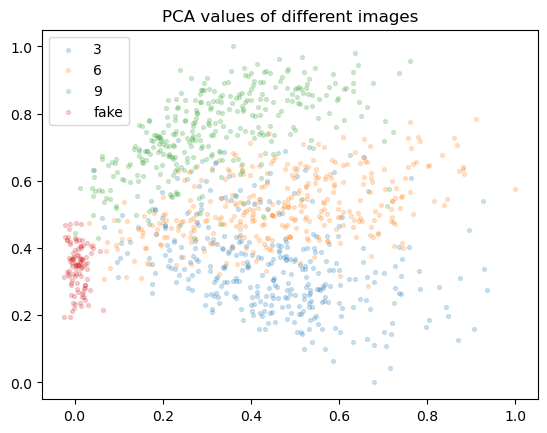

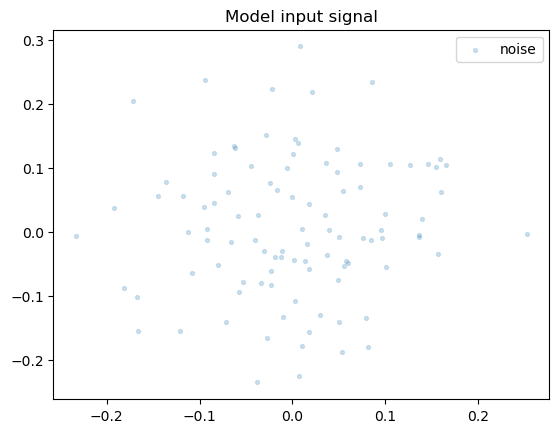

In [61]:
# temp cell
# distributions visualization

def get_latent(size):
    return torch.randn(size, latent_size).to(device)/10


vis_dims = [0, 1]
n_samples = 1000

labels = data_labels.unique()
for l in labels:
    index = data_labels == l
    plt.scatter(pca_data[index, vis_dims[0]], 
                pca_data[index, vis_dims[1]], label=l.item(), alpha=0.2, s=8)
plt.title("PCA values of different images")

with torch.no_grad():
    fake_data = np.array(gen_data(get_latent(n_samples)))
    
plt.scatter(fake_data[:, vis_dims[0]], 
            fake_data[:, vis_dims[1]], label="fake", alpha=0.2, s=8)
    
plt.legend()
plt.show()

noise = get_latent(n_samples)
plt.scatter(noise[:, 0], 
            noise[:, 1], label="noise", alpha=0.2, s=8)
plt.title("Model input signal")
plt.legend()

None